In [63]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from mnist_model import Net
from tabulate import tabulate

## Variables

In [2]:
PATIENCE = 20
PATH = 'trained_models\\'
FIG_PATH = 'illustrations_and_results\\'
MNIST_CNN_PATH = 'trained_models\mnist_cnn_epoch62.pt'
PIC_DIM = 28
EPS = 0.25
C = 1
GAMMA = 0.0
THR = 0.0

## Basic model and loss function

In [3]:
def custom_loss(output, noise, target, cnn):
    preds = cnn(output)
    loss = C / F.nll_loss(preds, target) + GAMMA * torch.sum(torch.abs(noise)) / len(noise)
    return loss


class PGEN_NN(nn.Module):
    def __init__(self):
        super(PGEN_NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2704, 1024)
        self.fc2 = nn.Linear(1024, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

## Train and evaluation functions

In [19]:
def train(args, model, device, train_loader, optimizer, epoch, cnn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, noise = model(data)
        loss = custom_loss(output, noise, target, cnn)  # F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, cnn, use_gen = True):
    model.eval()
    test_loss = 0
    noise_count = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if use_gen:
                output, noise = model.generate(data, device)
            else:
                output, noise = model(data)    
            noise_count += torch.sum(torch.abs(noise))
            test_loss += custom_loss(output, noise, target,
                                     cnn) * len(data)
            output = cnn(output)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTesting set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), noise average = {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset),
        noise_count / len(test_loader.dataset)))

    return test_loss, 100. * correct / len(test_loader.dataset)

## Runner function

In [5]:
def main(args, model, optimizer, cnn, train_loader, dev_loader, device):
    
    dev_losses = []
    train_losses = []
    dev_accuracy = []
    train_accuracy = []

    if not args['load_model']:  # don't need to load
        best_epoch = 0
        best_loss = float('inf')
        start_time = time.time()
        # run training
        for epoch in range(1, args['epochs'] + 1):
            train(args, model, device, train_loader, optimizer, epoch, cnn)
            
            print('Testing train set:')
            train_loss, train_acc = test(model, device, train_loader, cnn)
            print('Testing dev set:')
            dev_loss, dev_acc = test(model, device, dev_loader, cnn)
            dev_losses.append(dev_loss)
            dev_accuracy.append(dev_acc)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
            
            if dev_loss < best_loss:  # found better epoch
                best_loss = dev_loss
                best_epoch = epoch
            if args['save_model']:  # need to save model
                model_name = args['model_name'] + '_epoch%d.pt' % epoch
                torch.save(model.state_dict(), PATH + model_name)

            """
            # add this section if want to use patience 
            if best_epoch + PATIENCE <= epoch:  # no improvement in the last PATIENCE epochs
                print('No improvement was done in the last %d epochs, breaking...' % PATIENCE)
                break
            """

        end_time = time.time()
        print('Training took %.3f seconds' % (end_time - start_time))
        print('Best model was achieved on epoch %d' % best_epoch)
        model_name =  args['model_name'] + '_epoch%d.pt' % best_epoch
        model.load_state_dict(torch.load(PATH + model_name))  # load model from best epoch
    else:  # need to load
        model.load_state_dict(torch.load(PATH + args['load_path']))
    
    return dev_losses, train_losses, dev_accuracy, train_accuracy

## Settings and hyperparameters initialization

In [6]:
args={}
# Training settings
args['batch_size'] = 64
args['test_batch_size'] = 1000
args['epochs'] = 120
args['no_cuda'] = False
args['seed'] = 1
args['log_interval'] = 100
args['save_model'] = True
args['load_model'] = False
args['load_path'] = ""
 
use_cuda = not args['no_cuda'] and torch.cuda.is_available()

torch.manual_seed(args['seed'])

device = torch.device("cuda" if use_cuda else "cpu")  # device to run the model on

# organize parsed data
train_kwargs = {'batch_size': args['batch_size']}
test_kwargs = {'batch_size': args['test_batch_size']}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

# get datasets and create loaders
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                            transform=transform)
train_set, dev_set = torch.utils.data.random_split(dataset1, [50_000, 10_000],
                                                    generator=torch.Generator().manual_seed(42))
dataset2 = datasets.MNIST('../data', train=False, download=True,
                            transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
dev_loader = torch.utils.data.DataLoader(dev_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

cnn = Net().to(device)
cnn.load_state_dict(torch.load(MNIST_CNN_PATH))
for param in cnn.parameters():
    param.requires_grad = False
_ = cnn.eval()


## Run model

In [7]:
# create model, initialize optimizer
args['model_name'] = 'pgen_nn'
model1 = PGEN_NN().to(device)
optimizer = optim.Adadelta(model1.parameters())

dev_losses, train_losses, dev_accuracy, train_accuracy = main(args, model1, optimizer, cnn,
                                                              train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 13.256638
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.006680
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.950120
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.018184
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.894203
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.872033
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.037432
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.020772
Testing train set:

Testing set: Average loss: 0.9251, Accuracy: 44521/50000 (89%), noise average = 781.6612

Testing dev set:

Testing set: Average loss: 0.9240, Accuracy: 8897/10000 (89%), noise average = 781.6533

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.031051
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.902947
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.933381
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.981135
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.937955
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.891808
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.013610
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.9

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.465489
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.460213
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.473166
Testing train set:

Testing set: Average loss: 0.4523, Accuracy: 11680/50000 (23%), noise average = 763.4688

Testing dev set:

Testing set: Average loss: 0.4525, Accuracy: 2351/10000 (24%), noise average = 763.3132

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.464303
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.465095
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.456787
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.451149
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.467723
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.454617
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.456711
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.465696
Testing train set:

Testing set: Average loss: 0.4505, Accuracy: 10977/50000 (22%), noise average = 763.8721

Testing dev set:

Testing set: Average loss: 0.4509, Accuracy: 2228/10000 (22%), noise average = 763.7258

Train Epoch


Testing set: Average loss: 0.4388, Accuracy: 7496/50000 (15%), noise average = 761.2292

Testing dev set:

Testing set: Average loss: 0.4394, Accuracy: 1539/10000 (15%), noise average = 761.0377

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.451788
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.437858
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.446450
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.440620
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.452309
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.436256
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.446214
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.447717
Testing train set:

Testing set: Average loss: 0.4381, Accuracy: 7413/50000 (15%), noise average = 761.1301

Testing dev set:

Testing set: Average loss: 0.4388, Accuracy: 1536/10000 (15%), noise average = 760.9154

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.444739
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.444851
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.444187
Train Epoch: 29 [19200/50000 (38%)]	Lo

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.109942
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.105932
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.110766
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.111864
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.120104
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.096659
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.111134
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.107173
Testing train set:

Testing set: Average loss: 0.0962, Accuracy: 6218/50000 (12%), noise average = 761.0199

Testing dev set:

Testing set: Average loss: 0.0965, Accuracy: 1244/10000 (12%), noise average = 760.9434

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.096960
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.098326
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.101526
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.104850
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.099756
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.107284
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.108554
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.082922
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.090391
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.085230
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.078896
Testing train set:

Testing set: Average loss: 0.0834, Accuracy: 4897/50000 (10%), noise average = 761.0312

Testing dev set:

Testing set: Average loss: 0.0838, Accuracy: 973/10000 (10%), noise average = 760.9064

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.091579
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.089813
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.086766
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.083860
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.083246
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.089770
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.073854
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.091999
Testing train set:

Testing set: Average loss: 0.0831, Accuracy: 4899/50000 (10%), noise average = 761.0702

Testing dev set:

Testing set: Average loss: 0.0835, Accuracy: 972/100

Testing train set:

Testing set: Average loss: 0.0800, Accuracy: 4889/50000 (10%), noise average = 760.1560

Testing dev set:

Testing set: Average loss: 0.0805, Accuracy: 970/10000 (10%), noise average = 759.9475

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.081210
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.081031
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.089331
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.079411
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.084060
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.088996
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.082629
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.073186
Testing train set:

Testing set: Average loss: 0.0799, Accuracy: 4890/50000 (10%), noise average = 760.3204

Testing dev set:

Testing set: Average loss: 0.0803, Accuracy: 971/10000 (10%), noise average = 760.1000

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.074042
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.089833
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.079219
Train Epoch: 69 [1920

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.079083
Train Epoch: 81 [6400/50000 (13%)]	Loss: 0.080582
Train Epoch: 81 [12800/50000 (26%)]	Loss: 0.088976
Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.072129
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.079118
Train Epoch: 81 [32000/50000 (64%)]	Loss: 0.085922
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.074936
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.080526
Testing train set:

Testing set: Average loss: 0.0774, Accuracy: 4889/50000 (10%), noise average = 758.2200

Testing dev set:

Testing set: Average loss: 0.0780, Accuracy: 969/10000 (10%), noise average = 757.9714

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.070212
Train Epoch: 82 [6400/50000 (13%)]	Loss: 0.084228
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.078070
Train Epoch: 82 [19200/50000 (38%)]	Loss: 0.077819
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.082662
Train Epoch: 82 [32000/50000 (64%)]	Loss: 0.074165
Train Epoch: 82 [38400/50000 (77%)]	Loss: 0.086603
Train Epoch: 82 [44800/50000 (90

Train Epoch: 94 [25600/50000 (51%)]	Loss: 0.080466
Train Epoch: 94 [32000/50000 (64%)]	Loss: 0.070994
Train Epoch: 94 [38400/50000 (77%)]	Loss: 0.083048
Train Epoch: 94 [44800/50000 (90%)]	Loss: 0.071030
Testing train set:

Testing set: Average loss: 0.0759, Accuracy: 4885/50000 (10%), noise average = 758.5084

Testing dev set:

Testing set: Average loss: 0.0764, Accuracy: 969/10000 (10%), noise average = 758.2151

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.075799
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.073810
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.081986
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.079013
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.079134
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.087495
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.074167
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.081995
Testing train set:

Testing set: Average loss: 0.0756, Accuracy: 4883/50000 (10%), noise average = 758.2852

Testing dev set:

Testing set: Average loss: 0.0763, Accuracy: 969/100

Train Epoch: 107 [44800/50000 (90%)]	Loss: 0.072911
Testing train set:

Testing set: Average loss: 0.0746, Accuracy: 4884/50000 (10%), noise average = 758.1996

Testing dev set:

Testing set: Average loss: 0.0753, Accuracy: 969/10000 (10%), noise average = 757.9246

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.077848
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.075705
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.081393
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.081207
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.072075
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.080779
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.084734
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.079984
Testing train set:

Testing set: Average loss: 0.0745, Accuracy: 4883/50000 (10%), noise average = 757.8489

Testing dev set:

Testing set: Average loss: 0.0751, Accuracy: 969/10000 (10%), noise average = 757.5760

Train Epoch: 109 [0/50000 (0%)]	Loss: 0.076182
Train Epoch: 109 [6400/50000 (13%)]	Loss: 0.072141
Train Epoc


Testing set: Average loss: 0.0737, Accuracy: 4883/50000 (10%), noise average = 758.1421

Testing dev set:

Testing set: Average loss: 0.0745, Accuracy: 969/10000 (10%), noise average = 757.8719

Training took 1065.897 seconds
Best model was achieved on epoch 119


In [22]:
print('Testing test set:')
_ = test(model1, device, test_loader, cnn)

Testing test set:

Testing set: Average loss: 0.0742, Accuracy: 974/10000 (10%), noise average = 757.7563



## Plot results

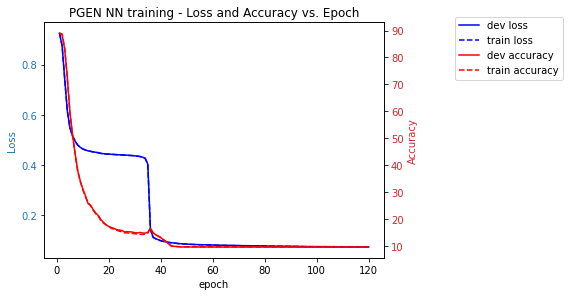

In [10]:
epochs = np.arange(1, args['epochs'] + 1)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss', color = color)
ax1.plot(epochs, dev_losses, 'b-', label = 'dev loss')
ax1.plot(epochs, train_losses, 'b--', label = 'train loss')
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Accuracy', color = color)  # we already handled the x-label with ax1
ax2.plot(epochs, dev_accuracy, 'r-', label='dev accuracy')
ax2.plot(epochs, train_accuracy, 'r--', label='train accuracy')
ax2.tick_params(axis='y', labelcolor = color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PGEN NN training - Loss and Accuracy vs. Epoch')
fig.savefig(FIG_PATH + 'PGEN NN training - Loss and Accuracy vs Epoch', bbox_inches='tight')
plt.show()

# # Models with different architecture

In [11]:
class PGEN_NN_PLS_CONV(nn.Module):
    def __init__(self):
        super(PGEN_NN_PLS_CONV, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = self.conv2(x)  # 32,24,24
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 32,12,12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = self.conv2(x)  # 32,24,24
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

In [12]:
class PGEN_NN_MNS_LIN(nn.Module):
    def __init__(self):
        super(PGEN_NN_MNS_LIN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2704, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

## Train PGEN_NN_PLS_CONV

In [13]:
# create model, initialize optimizer
args['model_name'] = 'pgen_nn_pls_conv'
model2 = PGEN_NN_PLS_CONV().to(device)
optimizer = optim.Adadelta(model2.parameters())

dev_losses_pls_conv, train_losses_pls_conv, dev_accuracy_pls_conv, train_accuracy_pls_conv = main(
    args, model2, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 179.617737
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.080553
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.793064
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.952486
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.932361
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.863638
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.946056
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.881064
Testing train set:

Testing set: Average loss: 0.9104, Accuracy: 43990/50000 (88%), noise average = 783.9991

Testing dev set:

Testing set: Average loss: 0.9052, Accuracy: 8840/10000 (88%), noise average = 783.9960

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.990094
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.966624
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.867216
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.953383
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.847264
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.852416
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.950220
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.442999
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.448223
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.442994
Testing train set:

Testing set: Average loss: 0.4400, Accuracy: 8141/50000 (16%), noise average = 769.8306

Testing dev set:

Testing set: Average loss: 0.4404, Accuracy: 1672/10000 (17%), noise average = 769.6655

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.433950
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.441921
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.445197
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.441237
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.444078
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.443219
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.443477
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.440711
Testing train set:

Testing set: Average loss: 0.4390, Accuracy: 7717/50000 (15%), noise average = 769.8270

Testing dev set:

Testing set: Average loss: 0.4395, Accuracy: 1562/10000 (16%), noise average = 769.6882

Train Epoch: 


Testing set: Average loss: 0.1082, Accuracy: 2730/50000 (5%), noise average = 768.0801

Testing dev set:

Testing set: Average loss: 0.1087, Accuracy: 558/10000 (6%), noise average = 767.9305

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.120299
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.122879
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.100779
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.100700
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.119547
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.110943
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.110495
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.102523
Testing train set:

Testing set: Average loss: 0.1024, Accuracy: 2152/50000 (4%), noise average = 768.1249

Testing dev set:

Testing set: Average loss: 0.1028, Accuracy: 429/10000 (4%), noise average = 768.0083

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.100718
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.108160
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.103489
Train Epoch: 29 [19200/50000 (38%)]	Loss: 0.

Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.081876
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.084762
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.075776
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.080460
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.094066
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.087748
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.085549
Testing train set:

Testing set: Average loss: 0.0767, Accuracy: 814/50000 (2%), noise average = 767.6118

Testing dev set:

Testing set: Average loss: 0.0773, Accuracy: 174/10000 (2%), noise average = 767.3944

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.076996
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.074709
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.085074
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.076951
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.079174
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.079061
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.083029
Train Epoch: 42 [44800/50000 (90%)]	Loss: 0.086121
Testing train set:

Testing se

Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.074534
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.076258
Testing train set:

Testing set: Average loss: 0.0695, Accuracy: 178/50000 (0%), noise average = 770.1666

Testing dev set:

Testing set: Average loss: 0.0702, Accuracy: 40/10000 (0%), noise average = 769.8728

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.075629
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.071987
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.078773
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.080952
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.066325
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.069835
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.068981
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.071568
Testing train set:

Testing set: Average loss: 0.0693, Accuracy: 158/50000 (0%), noise average = 770.2805

Testing dev set:

Testing set: Average loss: 0.0700, Accuracy: 34/10000 (0%), noise average = 769.9864

Train Epoch: 56 [0/50000 (0%)]	Loss: 0.068263
Train Epoch: 56 [6400/50000 


Testing set: Average loss: 0.0682, Accuracy: 23/10000 (0%), noise average = 770.3400

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.073401
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.076485
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.063629
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.070584
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.071853
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.070909
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.065483
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.063940
Testing train set:

Testing set: Average loss: 0.0673, Accuracy: 109/50000 (0%), noise average = 770.7414

Testing dev set:

Testing set: Average loss: 0.0680, Accuracy: 26/10000 (0%), noise average = 770.3209

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.071980
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.068723
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.071830
Train Epoch: 69 [19200/50000 (38%)]	Loss: 0.061960
Train Epoch: 69 [25600/50000 (51%)]	Loss: 0.064551
Train Epoch: 69 [32000/50000 (64%)]	Loss: 0.071320


Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.063460
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.065378
Train Epoch: 81 [32000/50000 (64%)]	Loss: 0.070496
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.071081
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.075388
Testing train set:

Testing set: Average loss: 0.0659, Accuracy: 88/50000 (0%), noise average = 770.9109

Testing dev set:

Testing set: Average loss: 0.0668, Accuracy: 18/10000 (0%), noise average = 770.3751

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.066233
Train Epoch: 82 [6400/50000 (13%)]	Loss: 0.065075
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.066957
Train Epoch: 82 [19200/50000 (38%)]	Loss: 0.071797
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.064085
Train Epoch: 82 [32000/50000 (64%)]	Loss: 0.065777
Train Epoch: 82 [38400/50000 (77%)]	Loss: 0.068524
Train Epoch: 82 [44800/50000 (90%)]	Loss: 0.075091
Testing train set:

Testing set: Average loss: 0.0658, Accuracy: 84/50000 (0%), noise average = 771.0036

Testing dev set:

Testing s

Testing train set:

Testing set: Average loss: 0.0650, Accuracy: 67/50000 (0%), noise average = 771.0030

Testing dev set:

Testing set: Average loss: 0.0658, Accuracy: 14/10000 (0%), noise average = 770.4185

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.075796
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.067134
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.072384
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.065860
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.068631
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.068820
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.068171
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.068016
Testing train set:

Testing set: Average loss: 0.0650, Accuracy: 64/50000 (0%), noise average = 771.0518

Testing dev set:

Testing set: Average loss: 0.0658, Accuracy: 16/10000 (0%), noise average = 770.4599

Train Epoch: 96 [0/50000 (0%)]	Loss: 0.067460
Train Epoch: 96 [6400/50000 (13%)]	Loss: 0.067047
Train Epoch: 96 [12800/50000 (26%)]	Loss: 0.066037
Train Epoch: 96 [19200/50000 (3

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.069748
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.068045
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.061218
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.064752
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.071857
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.066618
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.070014
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.068854
Testing train set:

Testing set: Average loss: 0.0643, Accuracy: 62/50000 (0%), noise average = 771.1295

Testing dev set:

Testing set: Average loss: 0.0651, Accuracy: 19/10000 (0%), noise average = 770.5042

Train Epoch: 109 [0/50000 (0%)]	Loss: 0.063915
Train Epoch: 109 [6400/50000 (13%)]	Loss: 0.063075
Train Epoch: 109 [12800/50000 (26%)]	Loss: 0.073519
Train Epoch: 109 [19200/50000 (38%)]	Loss: 0.070694
Train Epoch: 109 [25600/50000 (51%)]	Loss: 0.069826
Train Epoch: 109 [32000/50000 (64%)]	Loss: 0.068694
Train Epoch: 109 [38400/50000 (77%)]	Loss: 0.064517
Train Epoch: 109 [4480

## Train PGEN_NN_MNS_LIN

In [14]:
# create model, initialize optimizer
args['model_name'] = 'pgen_nn_mns_lin'
model3 = PGEN_NN_MNS_LIN().to(device)
optimizer = optim.Adadelta(model3.parameters())

dev_losses_mns_lin, train_losses_mns_lin, dev_accuracy_mns_lin, train_accuracy_mns_lin = main(
    args, model3, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 45.053841
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.119938
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.872797
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.800594
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.849874
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.769556
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.776529
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.758868
Testing train set:

Testing set: Average loss: 0.7281, Accuracy: 41773/50000 (84%), noise average = 759.6080

Testing dev set:

Testing set: Average loss: 0.7251, Accuracy: 8372/10000 (84%), noise average = 759.5005

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.707623
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.713824
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.708891
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.778437
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.692046
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.681631
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.639557
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.6

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.522233
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.522405
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.528382
Testing train set:

Testing set: Average loss: 0.5089, Accuracy: 25255/50000 (51%), noise average = 741.4574

Testing dev set:

Testing set: Average loss: 0.5095, Accuracy: 5094/10000 (51%), noise average = 741.2071

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.540867
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.491142
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.510963
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.509709
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.509907
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.510938
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.494405
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.503101
Testing train set:

Testing set: Average loss: 0.5059, Accuracy: 24665/50000 (49%), noise average = 741.9452

Testing dev set:

Testing set: Average loss: 0.5065, Accuracy: 4985/10000 (50%), noise average = 741.6955

Train Epoch

Testing train set:

Testing set: Average loss: 0.4770, Accuracy: 18221/50000 (36%), noise average = 737.9475

Testing dev set:

Testing set: Average loss: 0.4776, Accuracy: 3714/10000 (37%), noise average = 737.6480

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.483907
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.469800
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.470391
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.473378
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.464417
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.481531
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.478771
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.470149
Testing train set:

Testing set: Average loss: 0.4744, Accuracy: 17486/50000 (35%), noise average = 737.9258

Testing dev set:

Testing set: Average loss: 0.4750, Accuracy: 3585/10000 (36%), noise average = 737.6356

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.476521
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.469581
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.491661
Train Epoch: 29 [

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.459233
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.456920
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.461965
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.471850
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.463277
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.473116
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.475402
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.472529
Testing train set:

Testing set: Average loss: 0.4610, Accuracy: 13924/50000 (28%), noise average = 734.3616

Testing dev set:

Testing set: Average loss: 0.4619, Accuracy: 2876/10000 (29%), noise average = 733.9575

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.461787
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.458282
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.469569
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.469492
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.466663
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.458827
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.465876
Train Epoch: 42 [44800/50000 (

Train Epoch: 54 [19200/50000 (38%)]	Loss: 0.450509
Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.448180
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.449627
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.448210
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.455350
Testing train set:

Testing set: Average loss: 0.4525, Accuracy: 11512/50000 (23%), noise average = 733.9830

Testing dev set:

Testing set: Average loss: 0.4533, Accuracy: 2357/10000 (24%), noise average = 733.5243

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.457306
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.445512
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.452805
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.447360
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.449737
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.451338
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.455845
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.450106
Testing train set:

Testing set: Average loss: 0.4522, Accuracy: 11397/50000 (23%), noise average = 734.0009

Testing dev set:

Train Epoch: 67 [38400/50000 (77%)]	Loss: 0.446847
Train Epoch: 67 [44800/50000 (90%)]	Loss: 0.449896
Testing train set:

Testing set: Average loss: 0.4511, Accuracy: 11100/50000 (22%), noise average = 733.2124

Testing dev set:

Testing set: Average loss: 0.4522, Accuracy: 2299/10000 (23%), noise average = 732.7056

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.442145
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.458652
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.445220
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.457659
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.450761
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.451496
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.455692
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.450106
Testing train set:

Testing set: Average loss: 0.4511, Accuracy: 11126/50000 (22%), noise average = 733.0417

Testing dev set:

Testing set: Average loss: 0.4521, Accuracy: 2295/10000 (23%), noise average = 732.5414

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.458490
Train Epoch: 69 


Testing set: Average loss: 0.4507, Accuracy: 2178/10000 (22%), noise average = 732.3386

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.446705
Train Epoch: 81 [6400/50000 (13%)]	Loss: 0.447248
Train Epoch: 81 [12800/50000 (26%)]	Loss: 0.444196
Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.450818
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.445115
Train Epoch: 81 [32000/50000 (64%)]	Loss: 0.450226
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.455036
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.440998
Testing train set:

Testing set: Average loss: 0.4498, Accuracy: 10660/50000 (21%), noise average = 732.7591

Testing dev set:

Testing set: Average loss: 0.4508, Accuracy: 2194/10000 (22%), noise average = 732.2606

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.447263
Train Epoch: 82 [6400/50000 (13%)]	Loss: 0.447540
Train Epoch: 82 [12800/50000 (26%)]	Loss: 0.458731
Train Epoch: 82 [19200/50000 (38%)]	Loss: 0.456504
Train Epoch: 82 [25600/50000 (51%)]	Loss: 0.454402
Train Epoch: 82 [32000/50000 (64%)]	Loss: 

Train Epoch: 94 [12800/50000 (26%)]	Loss: 0.448553
Train Epoch: 94 [19200/50000 (38%)]	Loss: 0.452150
Train Epoch: 94 [25600/50000 (51%)]	Loss: 0.444145
Train Epoch: 94 [32000/50000 (64%)]	Loss: 0.441183
Train Epoch: 94 [38400/50000 (77%)]	Loss: 0.443062
Train Epoch: 94 [44800/50000 (90%)]	Loss: 0.455188
Testing train set:

Testing set: Average loss: 0.4475, Accuracy: 10117/50000 (20%), noise average = 732.2856

Testing dev set:

Testing set: Average loss: 0.4486, Accuracy: 2059/10000 (21%), noise average = 731.7683

Train Epoch: 95 [0/50000 (0%)]	Loss: 0.452005
Train Epoch: 95 [6400/50000 (13%)]	Loss: 0.444654
Train Epoch: 95 [12800/50000 (26%)]	Loss: 0.446359
Train Epoch: 95 [19200/50000 (38%)]	Loss: 0.449547
Train Epoch: 95 [25600/50000 (51%)]	Loss: 0.439543
Train Epoch: 95 [32000/50000 (64%)]	Loss: 0.442644
Train Epoch: 95 [38400/50000 (77%)]	Loss: 0.451542
Train Epoch: 95 [44800/50000 (90%)]	Loss: 0.443193
Testing train set:

Testing set: Average loss: 0.4473, Accuracy: 10036/5000

Train Epoch: 107 [25600/50000 (51%)]	Loss: 0.440013
Train Epoch: 107 [32000/50000 (64%)]	Loss: 0.449008
Train Epoch: 107 [38400/50000 (77%)]	Loss: 0.446120
Train Epoch: 107 [44800/50000 (90%)]	Loss: 0.449693
Testing train set:

Testing set: Average loss: 0.4459, Accuracy: 9615/50000 (19%), noise average = 732.4130

Testing dev set:

Testing set: Average loss: 0.4470, Accuracy: 1971/10000 (20%), noise average = 731.9159

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.448485
Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.450101
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.445836
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.442259
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.449210
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.439655
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.441936
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.451285
Testing train set:

Testing set: Average loss: 0.4452, Accuracy: 9387/50000 (19%), noise average = 732.5015

Testing dev set:

Testing set: Average loss: 0.4463, Accu

Train Epoch: 120 [38400/50000 (77%)]	Loss: 0.439752
Train Epoch: 120 [44800/50000 (90%)]	Loss: 0.444215
Testing train set:

Testing set: Average loss: 0.4439, Accuracy: 9050/50000 (18%), noise average = 732.3276

Testing dev set:

Testing set: Average loss: 0.4450, Accuracy: 1867/10000 (19%), noise average = 731.8139

Training took 1498.768 seconds
Best model was achieved on epoch 119


## Plot comperative graphs

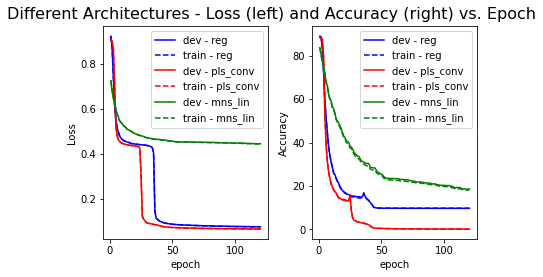

In [15]:
epochs = np.arange(1, args['epochs'] + 1)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss')
ax1.plot(epochs, dev_losses, 'b-', label = 'dev - reg')
ax1.plot(epochs, train_losses, 'b--', label = 'train - reg')
ax1.plot(epochs, dev_losses_pls_conv, 'r-', label = 'dev - pls_conv')
ax1.plot(epochs, train_losses_pls_conv, 'r--', label = 'train - pls_conv')
ax1.plot(epochs, dev_losses_mns_lin, 'g-', label = 'dev - mns_lin')
ax1.plot(epochs, train_losses_mns_lin, 'g--', label = 'train - mns_lin')
ax1.tick_params(axis='y')

ax2.set_xlabel('epoch')
ax2.set_ylabel('Accuracy') 
ax2.plot(epochs, dev_accuracy, 'b-', label = 'dev - reg')
ax2.plot(epochs, train_accuracy, 'b--', label = 'train - reg')
ax2.plot(epochs, dev_accuracy_pls_conv, 'r-', label = 'dev - pls_conv')
ax2.plot(epochs, train_accuracy_pls_conv, 'r--', label = 'train - pls_conv')
ax2.plot(epochs, dev_accuracy_mns_lin, 'g-', label = 'dev - mns_lin')
ax2.plot(epochs, train_accuracy_mns_lin, 'g--', label = 'train - mns_lin')
ax2.tick_params(axis='y')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
fig.suptitle('Different Architectures - Loss (left) and Accuracy (right) vs. Epoch', fontsize=16)
fig.savefig(FIG_PATH + 'Different Architectures - Loss and Accuracy vs Epoch', bbox_inches='tight')
plt.show()

In [16]:
print('Testing test set:')
_ = test(model2, device, test_loader, cnn)

Testing test set:

Testing set: Average loss: 0.0648, Accuracy: 22/10000 (0%), noise average = 770.6101



## AIC and BIC comparisons

In [65]:
def likelihood_comp(data_loader, model, device, cnn):
    model.eval()
    avg_likelihhod = 0
    num_exm = len(data_loader.dataset)
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output, noise = model.generate(data, device)  
            output = 1 - torch.exp(cnn(output))
            mask = torch.zeros(len(target), 10).to(device)
            mask.scatter_(1, target.unsqueeze(1), 1.)
            output = torch.sum(output * mask, dim = 1)
            avg_likelihhod += torch.sum(output) / num_exm

    return avg_likelihhod.item()

def number_of_params(model):
    """
    :inputs: cnn model
    :return number of weights in the model
    :rtype: int
    """
    params = model.parameters()
    count = 0
    for param in params:
        num_params = list(torch.reshape(param, (-1,)).size())[0]
        count += num_params
    return count

def calculate_BIC(likelihood, model, sample_size):
    """
    Calculate the Bayesian Information Criterion (BIC) for a GPy `model` with maximum likelihood hyperparameters on a given dataset
    https://enwikipediaorg/wiki/Bayesian_information_criterion
    """
    # likelihood is the natural logarithm of the marginal likelihood of the Gaussian process
    # sample_size is the number of data points
    # number_of_params() is the number of optimisation parameters
    return - 2 * np.log(likelihood) + np.log(sample_size) * number_of_params(model)

def calculate_AIC(likelihood, model):
    # likelihood is the natural logarithm of the marginal likelihood of the Gaussian process
    # sample_size is the number of data points
    return - 2 * np.log(likelihood) + 2 * number_of_params(model)

In [68]:
dev_sample_size = len(dev_loader.dataset)

model1_dev_likelihood = likelihood_comp(dev_loader, model1, device, cnn)
model2_dev_likelihood = likelihood_comp(dev_loader, model2, device, cnn)
model3_dev_likelihood = likelihood_comp(dev_loader, model3, device, cnn)

model1_dev_aic = calculate_AIC(model1_dev_likelihood, model1)
model2_dev_aic = calculate_AIC(model2_dev_likelihood, model2)
model3_dev_aic = calculate_AIC(model3_dev_likelihood, model3)

model1_dev_bic = calculate_BIC(model1_dev_likelihood, model1, dev_sample_size)
model2_dev_bic = calculate_BIC(model2_dev_likelihood, model2, dev_sample_size)
model3_dev_bic = calculate_BIC(model3_dev_likelihood, model3, dev_sample_size)

table = [["AIC", model1_dev_aic, model2_dev_aic, model3_dev_aic],
        ["BIC", model1_dev_bic, model2_dev_bic, model3_dev_bic]]
print("dev set comparison:")
print(tabulate(table, headers=["Regular model", "PLS_CONV", "MNS_LIN"]))

dev set comparison:
       Regular model     PLS_CONV      MNS_LIN
---  ---------------  -----------  -----------
AIC      7.14736e+06  1.1056e+07   4.24176e+06
BIC      3.29148e+07  5.09149e+07  1.9534e+07


In [67]:
train_sample_size = len(train_loader.dataset)

model1_train_likelihood = likelihood_comp(train_loader, model1, device, cnn)
model2_train_likelihood = likelihood_comp(train_loader, model2, device, cnn)
model3_train_likelihood = likelihood_comp(train_loader, model3, device, cnn)

model1_train_aic = calculate_AIC(model1_train_likelihood, model1)
model2_train_aic = calculate_AIC(model2_train_likelihood, model2)
model3_train_aic = calculate_AIC(model3_train_likelihood, model3)

model1_train_bic = calculate_BIC(model1_train_likelihood, model1, train_sample_size)
model2_train_bic = calculate_BIC(model2_train_likelihood, model2, train_sample_size)
model3_train_bic = calculate_BIC(model3_train_likelihood, model3, train_sample_size)

table = [["AIC", model1_train_aic, model2_train_aic, model3_train_aic],
        ["BIC", model1_train_bic, model2_train_bic, model3_train_bic]]
print("train set comparison:")
print(tabulate(table, headers=["Regular model", "PLS_CONV", "MNS_LIN"]))

train set comparison:
       Regular model     PLS_CONV      MNS_LIN
---  ---------------  -----------  -----------
AIC      7.14736e+06  1.1056e+07   4.24176e+06
BIC      3.86664e+07  5.98119e+07  2.29475e+07
